In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import random
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


In [2]:
import allensdk
import pandas
import h5py
import pynwb
import hdmf
import matplotlib
import scipy
print('allensdk', allensdk.__version__)
print('pandas', pandas.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)
print('scipy', scipy.__version__)

allensdk 2.2.0
pandas 1.1.1
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.4.1
scipy 1.6.2


# Data generator

#### Poisson

In [645]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
lmbd_0, lmbd_1 = 20, 20
trial_length, num_trials = 2, 500
spike_times_x = generator.generate_poisson_spike_times(lmbd_0, trial_length, num_trials)
spike_times_y = generator.generate_poisson_spike_times(lmbd_1, trial_length, num_trials)

#### Hawkes process

In [659]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 2
generator_par = {'trial_length': trial_length, 'trial_window':[0, trial_length], 'num_trials': 500, 'random_seed': None,
    'type': 'triangle', 'mu': [20., 20.], 'alpha': [[0., 0], [0.0, 0.0]], 'beta': [[1.0, 0.05], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_hawkes_spike_times(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

lambda stable: [20. 20.]
Gamma
[[0. 0.]
 [0. 0.]]
100%|█████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 53.76it/s]


#### Linear Cox + Gaussian window.

In [564]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 5
trial_window = [0, trial_length]
generator_par = {'num_trials': 100, 'trial_length': trial_length, 'trial_window': trial_window,
    'rho': 30, 'mu': 30, 'baseline': 10, 'window': 'gaussian', 'sigma': 0.1, 'random_seed': 222,
    'type': 'square', 'alpha': [[0., 2], [0.0, 0.0]], 'beta': [[1.0, 0.03], [1.0, 1.0]], 'num_nodes': 2}
spike_times = generator.generate_amarasingham_coupling_filter_spike_times_nonrepeated(generator_par, verbose=2)
spike_times_x = spike_times[1]
spike_times_y = spike_times[0]

100%|█████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


#### Check data statistics.

layers 3, nodes 2, trials 1000
meanFR [23.94  19.789]	meanISI [24.243 20.072]


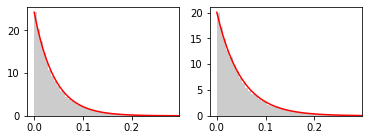

layers 3, nodes 2, trials 1000


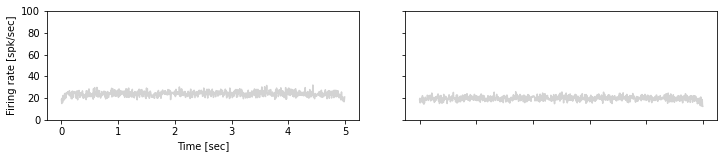

In [706]:
generator.spike_times_statistics(spike_times, generator_par['trial_length'], verbose=1)
_=generator.plot_psth(spike_times, generator_par['trial_length'], 0.005, ylim=[0, 100])
# generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, node_ids=[0,1], trial_ids=[0], plot_window=[0, 0.5], ylim=[None, None])

# Bayesian inference.

In [25]:
jittertool = jitter.JitterTool()
data_dir = project_dir + 'Output/jitter/bivariate_coupling_data/'
model_dir = project_dir + 'Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bayesian/'
model_name = 'poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated'

file_path = data_dir + f'{model_name}_generator_par.pkl'
generator_par = util.load_variable(file_path, verbose=False)
trial_length = generator_par['trial_length']

kernel_width = 125
model_par = {'filter_type': 'square', 'filter_length': generator_par['beta'][0][1],
             'append_nuisance': ['const', 'gaussian_kernel'], 'kernel_width': kernel_width/1000,
             'const_offset': 0, 'learning_rate': 0.5, 'max_num_itrs': 500, 'epsilon': 1e-5}
itr = 7
file_path = data_dir + f'{model_name}_itr{itr}.pkl'
spike_times = util.load_variable(file_path, verbose=False)
spike_times_x, spike_times_y = spike_times[1], spike_times[0]
num_trials = 200

In [26]:
model_par_hat = jittertool.bivariate_continuous_time_coupling_filter_regression(
        spike_times_x[:num_trials], spike_times_y[:num_trials], [0,trial_length], model_par, verbose=False)

In [27]:
num_samples = 1000
sample_kernel = True
beta_samples, kernel_samples = jittertool.bivariate_continuous_time_coupling_filter_bayesian(
        spike_times_x[:num_trials], spike_times_y[:num_trials], [0,trial_length], model_par_hat,
        num_samples=num_samples, sample_kernel=sample_kernel, verbose=True)

file_path = model_dir + f'{model_name}_itr{itr}_subtrials{num_trials}_samplekernel{sample_kernel}_bayesian_{time.strftime("%Y%m%d_%H%M%S")}.pkl'
util.save_variable(file_path, (beta_samples, kernel_samples))


100%|█████████████████████████████████████████████████████████| 1000/1000 [1:40:34<00:00,  6.03s/it]
acceptance ratio 0.476
util.save_variable, save variable to:  D:/Brain_Network/Output/jitter/bivariate_coupling_model/poisson_background_gaussian_mixture_point_process_bayesian/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_itr7_subtrials200_samplekernelTrue_bayesian_20211114_154634.pkl


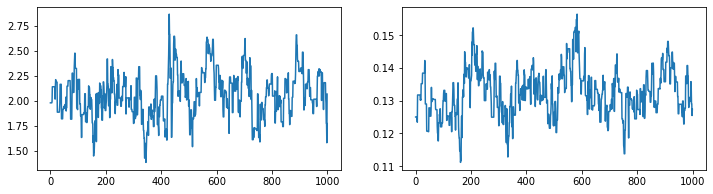

CI_left 1.63, CI_right 2.57, mode 2.04
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_itr7_subtrials200_samplekernelTrue_bayesian_hatbeta_h_posterior.pdf


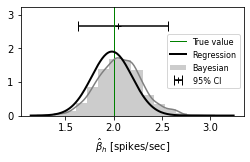

CI_left 118.66, CI_right 148.12, mode 130.15
save figure: D:/Brain_Network/Output/fig/poisson_background_gaussian_mixture_square_alpha2_beta30ms_sigma100ms_trials200_nonrepeated_itr7_subtrials200_samplekernelTrue_bayesian_sigmaW_posterior.pdf


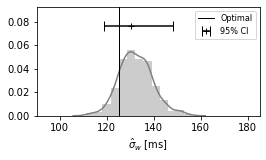

In [36]:
output_dir = project_dir + 'Output/fig/'
experiment_name = f'{model_name}_itr{itr}_subtrials{num_trials}_samplekernel{sample_kernel}_bayesian_'
jittertool.plot_beta_kernel_samples(beta_samples, kernel_samples, model_par_hat, generator_par,
        selected_kernel_width=125, experiment_name=experiment_name, output_dir=output_dir)

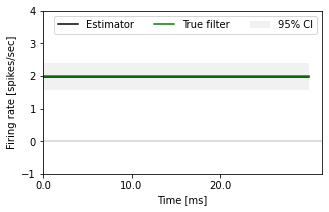

In [29]:
jittertool.plot_continuous_time_bivariate_regression_model_par(model_par_hat, generator_par, ylim=[-1,4], file_path=None)

### Jitter detection.

100%|█████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 38.15it/s]


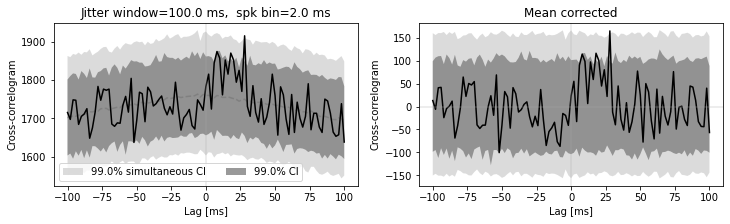

In [379]:
jittertool = jitter.JitterTool()
length = trial_length
spk_bin_width = 0.002
lag_range = [-0.1, 0.1]
jitter_window_width = 0.1
num_jitter = 500
distribution_type='mc_sim' # poisson, binom, mc_sim

_ = jittertool.cross_correlation_jitter(spike_times_x, spike_times_y, spk_bin_width, length, lag_range, 
    jitter_window_width=jitter_window_width, distribution_type=distribution_type, num_jitter=num_jitter, ci_alpha=0.01, verbose=2)